In [177]:
# Imports
import numpy
import numpy as np
import scipy
import tqdm
import reservoirpy
from reservoirpy import datasets
import matplotlib.pyplot as plt

reservoirpy.verbosity(0)

0

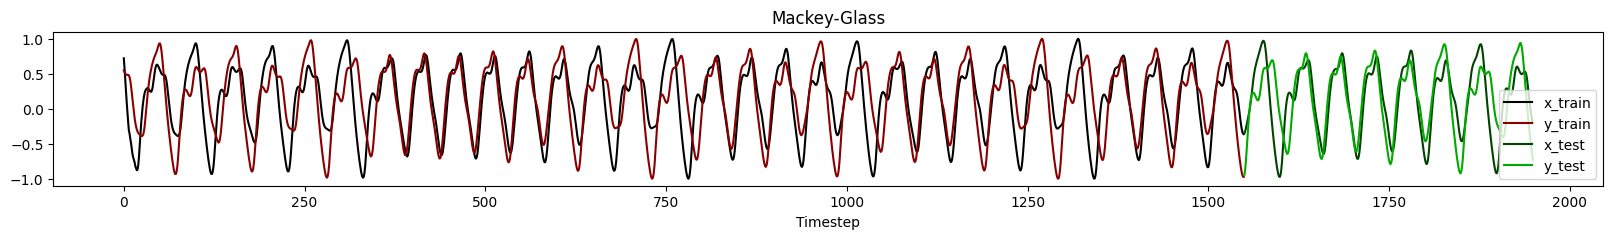

(1550, 1) (400, 1) (1550, 1) (400, 1)


In [178]:
# Dataset pour les tests
mackey_glass = datasets.mackey_glass(2000, tau=17)

# rescale between -1 and 1
mackey_glass = 2 * (mackey_glass - mackey_glass.min()) / (mackey_glass.max() - mackey_glass.min()) - 1

forecast = 50

mg_dataset = datasets.to_forecasting(
    mackey_glass, 
    forecast=forecast, 
    test_size=0.2
)
x_train, x_test, y_train, y_test = mg_dataset

import matplotlib.pyplot as plt

sep = x_train.shape[0]

plt.figure(figsize=(20,2))
plt.plot(np.arange(0, sep), x_train, color="black", label="x_train")
plt.plot(np.arange(0, sep), y_train, color="#880000", label="y_train")
plt.plot(np.arange(sep, sep+x_test.shape[0]), x_test, '-', color="#004400", label="x_test")
plt.plot(np.arange(sep, sep+y_test.shape[0]), y_test, '-', color="#00AA00", label="y_test")
plt.legend()
plt.xlabel("Timestep")
plt.title("Mackey-Glass")

plt.show()

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

In [179]:
# Évalue le score d'un modèle avec une matrice W donnée en entrée
# a des HP par défaut (pris du tuto 3 de RPY sur la même tâche sauf que c'est une prédiction à t+50)
def eval_reservoir(W=None, dataset=mg_dataset):
    x_train, x_test, y_train, y_test = dataset
    # repris du tuto 3
    units = 100
    leak_rate = 0.3
    spectral_radius = 1.25
    input_scaling = 1.0
    connectivity = 0.1
    input_connectivity = 0.2
    regularization = 1e-8
    seed = 1234

    from reservoirpy.nodes import Reservoir, Ridge
    if W is None:
        reservoir = Reservoir(
            units, 
            input_scaling=input_scaling, 
            sr=spectral_radius,
            lr=leak_rate, 
            rc_connectivity=connectivity,
            input_connectivity=input_connectivity, 
            seed=seed
        )
    else:
        reservoir = Reservoir(
            W=W,
            input_scaling=input_scaling, 
            sr=spectral_radius,
            lr=leak_rate, 
            input_connectivity=input_connectivity, 
            seed=seed
        )
    readout = Ridge(1, ridge=regularization)

    model = reservoir >> readout
    
    model(x_train[0])
    model.fit(x_train, y_train)

    y_pred = model.run(x_test)
    return reservoirpy.observables.rsquare(y_test, y_pred), reservoirpy.observables.nrmse(y_test, y_pred)

In [180]:
# performance d'un réservoir sans contrôle de rang (normal)
# baseline
print("R2, NRMSE", end=" = ")
print(eval_reservoir())

R2, NRMSE = (0.992473235841245, 0.0219376119181855)


In [181]:
# renvoie des infos sur une matrice W
def matrix_stat(W):
    print("shape =", W.shape)
    if type(W) != numpy.ndarray:
        print("Rank =", numpy.linalg.matrix_rank(W.toarray()))
    else:
        print("Rank =", numpy.linalg.matrix_rank(W))
    print("Non-zeros count =", W.nonzero()[0].shape[0])
    print("Non-zeros ratio =", W.nonzero()[0].shape[0] / (W.shape[0] * W.shape[1]))

# Rang d'une matrice dans ReservoirPy

100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


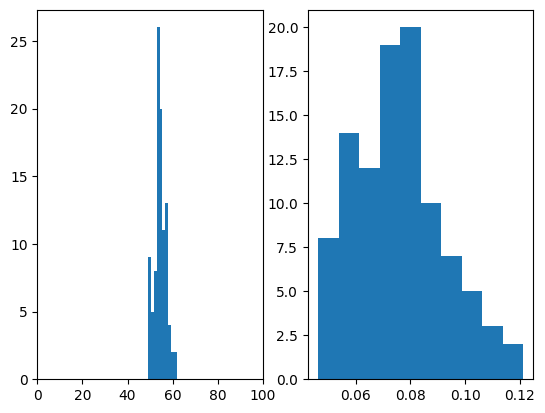

In [182]:
# Distribution du rang d'une matrice générée par RPY avec les hypers ci-dessous
units = 100
rc_connectivity = 0.01

ranks = []
nrmse = []
for i in tqdm.tqdm(range(100)):
    reservoir = reservoirpy.nodes.Reservoir(units=units, rc_connectivity=rc_connectivity)
    reservoir.initialize(numpy.eye(1))
    ranks.append(numpy.linalg.matrix_rank(reservoir.W.toarray()))
    nrmse.append(eval_reservoir(reservoir.W)[1])

plt.figure()
plt.subplot(1,2,1)
plt.hist(ranks)
plt.xlim(0, units)
plt.subplot(1,2,2)
plt.hist(nrmse)
plt.show()

shape = (100, 100)
Rank = 100
Non-zeros count = 1000
Non-zeros ratio = 0.1


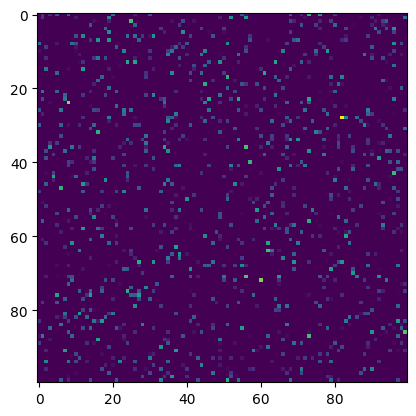

In [183]:
reservoir = reservoirpy.nodes.Reservoir(100)

reservoir.initialize(numpy.eye(1))

matrix_stat(reservoir.W)

plt.figure()
plt.imshow(numpy.abs(reservoir.W.toarray()))
plt.show()

# Génération de matrices de rang particulier

## I - Non-éparse (méthode d'Alexis)

In [184]:
# Hyper-paramètres
units = 100
rank = 1
seed = 2341
rng = numpy.random.default_rng(seed=seed)

In [185]:
# Génération de W (non-éparse)

m = rng.standard_normal(units).reshape(-1, 1)
n = rng.standard_normal(units).reshape(1, -1)

W = m @ n

In [186]:
numpy.linalg.matrix_rank(W)

1

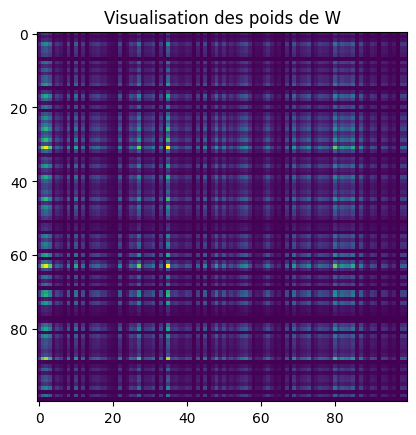

In [187]:
plt.figure()
plt.imshow(np.abs(W))
plt.title("Visualisation des poids de W")
plt.show()

In [188]:
matrix_stat(W)
eval_reservoir(W)

shape = (100, 100)
Rank = 1
Non-zeros count = 10000
Non-zeros ratio = 1.0


(0.5498005148527991, 0.16966321500579684)

## II - Éparse
On reprend la méthode d'Alexis (multiplication de matrices ligne-colonne) pour fixer le rang, et on tente d'avoir des matrices éparses.


Ici on adapte la densité des matrices ligne/colonne, pour conserver la même connectivité/éparsité du réservoir.
La connectivité de ce genre de matrice est d'environ $connectivity = 1 - (1 - density^2)^{rank}$. Donc on définit $density = \sqrt{1 - exp({ln(1 - connectivity) \over rank})}$

In [189]:
# real_connectivity = W.nonzero()[0].shape[0] / (W.shape[0] * W.shape[1])
# connectivity1 = rank * density**2
# connectivity2 = 1 - (1 - density**2)**rank

# print(f"real : {real_connectivity} ; connec1 : {connectivity1} ; connec2 : {connectivity2}")

shape = (100, 100)
Rank = 98
Non-zeros count = 5124
Non-zeros ratio = 0.5124
Density =  0.08352863800890425


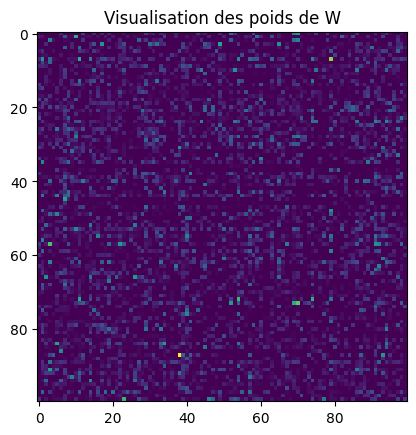

(-0.6463013918133522, 0.32444409033851057)

In [193]:
units = 100
rank = 99
connectivity = 0.5


density = np.sqrt(1 - np.exp(np.log(1 - connectivity) / rank))
m = scipy.sparse.random(units, rank, density=density, random_state=rng, data_rvs=scipy.stats.norm().rvs)
n = scipy.sparse.random(rank, units, density=density, random_state=rng, data_rvs=scipy.stats.norm().rvs)

W = m @ n

matrix_stat(W)
print("Density = ", density)

plt.figure()
plt.imshow(numpy.abs(W.toarray()))
plt.title("Visualisation des poids de W")
plt.show()

eval_reservoir(W)

On constate que le rang attendu avec cette méthode n'est pas celui obtenu en pratique. C'est d'autant plus vrai que `rank` est élevé.

**TODO:** comprendre et régler ça.

100%|██████████| 100/100 [07:25<00:00,  4.46s/it]


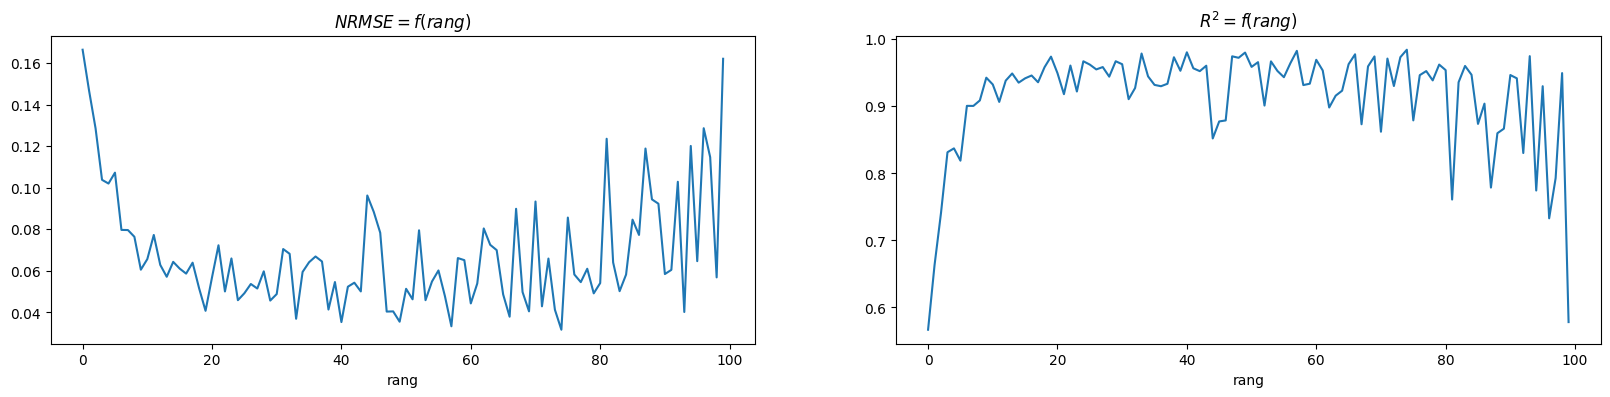

In [191]:
# score = f(~rank)
nrmses = []
r2s = []
iters = 10

for rank in tqdm.tqdm(list(range(1, units+1))):
    nrmses_in = []
    r2s_in = []

    for i in range(iters):
        density = np.sqrt(1 - np.exp(np.log(1 - connectivity) / rank))
        m = scipy.sparse.random(units, rank, density=density, random_state=rng, data_rvs=scipy.stats.norm().rvs)
        n = scipy.sparse.random(rank, units, density=density, random_state=rng, data_rvs=scipy.stats.norm().rvs)

        W = m @ n

        r2, nrmse = eval_reservoir(W)

        nrmses_in.append(nrmse)
        r2s_in.append(r2)
    
    nrmses.append(np.median(nrmses_in))
    r2s.append(np.median(r2s_in))

plt.figure(figsize=(20,4))
plt.subplot(1, 2, 1)
plt.plot(nrmses)
plt.xlabel("rang")
plt.title("$NRMSE = f(rang voulu)$")
plt.subplot(1, 2, 2)
plt.plot(r2s)
plt.title("$R^2 = f(rang voulu)$")
plt.xlabel("rang")
plt.show()

In [192]:
rank = 100

nrmses_in = []
r2s_in = []

for i in range(iters):
    density = np.sqrt(1 - np.exp(np.log(1 - connectivity) / rank))
    m = scipy.sparse.random(units, rank, density=density, random_state=rng, data_rvs=scipy.stats.norm().rvs)
    n = scipy.sparse.random(rank, units, density=density, random_state=rng, data_rvs=scipy.stats.norm().rvs)

    W = m @ n
    matrix_stat(W)

    r2, nrmse = eval_reservoir(W)

    nrmses_in.append(nrmse)
    r2s_in.append(r2)

np.median(nrmses_in), np.median(r2s_in)

shape = (100, 100)
Rank = 89
Non-zeros count = 1023
Non-zeros ratio = 0.1023
shape = (100, 100)
Rank = 95
Non-zeros count = 999
Non-zeros ratio = 0.0999
shape = (100, 100)
Rank = 91
Non-zeros count = 972
Non-zeros ratio = 0.0972
shape = (100, 100)
Rank = 92
Non-zeros count = 1038
Non-zeros ratio = 0.1038
shape = (100, 100)
Rank = 93
Non-zeros count = 956
Non-zeros ratio = 0.0956
shape = (100, 100)
Rank = 93
Non-zeros count = 1030
Non-zeros ratio = 0.103
shape = (100, 100)
Rank = 93
Non-zeros count = 973
Non-zeros ratio = 0.0973
shape = (100, 100)
Rank = 88
Non-zeros count = 1040
Non-zeros ratio = 0.104
shape = (100, 100)
Rank = 89
Non-zeros count = 965
Non-zeros ratio = 0.0965
shape = (100, 100)
Rank = 90
Non-zeros count = 987
Non-zeros ratio = 0.0987


(0.07964077061386649, 0.882892069660796)